In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *
from sklearn.utils import shuffle

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

Using TensorFlow backend.


In [2]:
batch_size = 4 * n_gpus
model_name = ''
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2.5
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [3]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=15,
                         zoom_range=0.2)
idg2 = ImageDataGenerator()

gen_train = idg.flow_from_directory('train', target_size=(height, width), 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
gen_valid = idg2.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                     interpolation='lanczos', classes=classes, batch_size=batch_size)
y_valid = (gen_valid.classes != 0).astype(int)

Found 1617 images belonging to 10 classes.
Found 405 images belonging to 10 classes.


In [4]:
a = [(x[x.rfind('-')+1:x.rfind('.')], x) for x in glob('models/*.h5')]
a = sorted(a, key=lambda x:x[0], reverse=True)[:50]
a

[('0.962335', 'models/irv2_0731-0.001001-120-0.962335.h5'),
 ('0.954866', 'models/irv2_0802-0.001000-30-0.954866.h5'),
 ('0.954225', 'models/irv2_0801-0.000100-60-0.954225.h5'),
 ('0.937116',
  'models/InceptionResNetV2_0803_f3.0_reg4e-05-0.000100-67-0.937116.h5'),
 ('0.936927',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-58-0.936927.h5'),
 ('0.935714',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-67-0.935714.h5'),
 ('0.935391',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-59-0.935391.h5'),
 ('0.934825',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.001000-39-0.934825.h5'),
 ('0.934690',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-68-0.934690.h5'),
 ('0.934557', 'models/irv2_0802_f3.75-0.000100-56-0.934557.h5'),
 ('0.934420',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.001000-31-0.934420.h5'),
 ('0.934340',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-66-0.934340.h5'),
 ('0.934219', 'models/irv2_0802-0.001000-29-0.934219.

# 构建模型

In [5]:
base_model = MODEL(include_top=False, weights=None)
input_tensor = Input((None, None, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
model_parallel = multi_gpu_model(model, n_gpus)

# 预测

In [7]:
fname_model = 'models/irv2_0731-0.001001-120-0.962335.h5'
model.load_weights(fname_model)

In [9]:
y_pred = model_parallel.predict_generator(gen_valid, verbose=1, workers=multiprocessing.cpu_count())

51/51 [==============================] - 44s 861ms/step


In [10]:
y_pred2 = 1 - y_pred[:,0]
y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
pprint(roc_auc_score(y_valid, y_pred2))
pprint(accuracy_score(y_valid, y_pred3))
pprint(confusion_matrix(y_valid > 0.5, y_pred3))

0.9616981132075473
0.908641975308642
array([[257,   8],
       [ 29, 111]])


In [11]:
y_pred4 = np.round(y_pred2, 6).clip(1e-6, 1-1e-6)

In [12]:
pprint(roc_auc_score(y_valid, y_pred4))

0.961711590296496


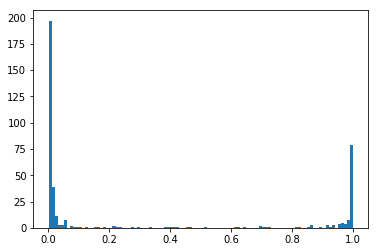

In [13]:
plt.hist(y_pred4, bins=100);

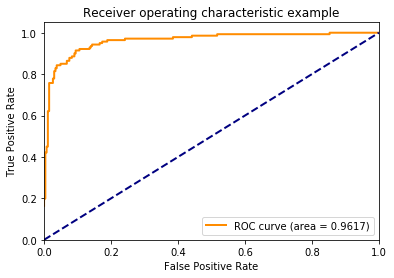

In [14]:
y_test = y_valid
y_score = y_pred4

fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 多次预测

In [8]:
fname_model = 'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-58-0.936927.h5'
model.load_weights(fname_model)

y_pred = model_parallel.predict_generator(gen_valid, verbose=1, workers=multiprocessing.cpu_count())
y_pred2 = 1 - y_pred[:,0]
y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
pprint(roc_auc_score(y_valid, y_pred2))
pprint(accuracy_score(y_valid, y_pred3))
pprint(confusion_matrix(y_valid > 0.5, y_pred3))

51/51 [==============================] - 20s 401ms/step
0.9369272237196765
0.8740740740740741
array([[246,  19],
       [ 32, 108]])


In [22]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=10,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)

Found 405 images belonging to 10 classes.


In [26]:
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
y_pred = np.mean(y_preds, axis=0)
y_pred2 = 1 - y_pred[:,0]
y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
pprint(roc_auc_score(y_valid, y_pred2))
pprint(accuracy_score(y_valid, y_pred3))
pprint(confusion_matrix(y_valid > 0.5, y_pred3))

51/51 [==============================] - 25s 483ms/step
0.9412938005390835
0.8790123456790123
array([[247,  18],
       [ 31, 109]])


In [28]:
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

0.9250943396226415
0.9284905660377358
0.9369541778975741
0.9370350404312668
0.9379514824797843
0.9406199460916442
0.9414824797843665
0.9415633423180593
0.9420485175202156
0.9412938005390835


In [29]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 25s 481ms/step
0.9261051212938005
0.928167115902965
0.9360512129380054
0.938921832884097
0.9416981132075471
0.9422371967654987
0.9430458221024259
0.9435849056603773
0.9433153638814016
0.943288409703504


In [34]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=3,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 23s 460ms/step
0.928733153638814
0.9385983827493262
0.9360916442048517
0.9391105121293801
0.9390026954177898
0.9395687331536389
0.9400269541778975
0.939811320754717
0.9401482479784367
0.9407008086253369


In [33]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=7,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 23s 460ms/step
0.9323180592991914
0.9373045822102426
0.9346630727762802
0.9360781671159031
0.9363611859838276
0.9352830188679246
0.9353638814016172
0.9366307277628032
0.9360377358490567
0.9366576819407008


In [31]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.2)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 24s 465ms/step
0.9197035040431267
0.9335309973045821
0.9366576819407008
0.9332614555256065
0.9333423180592991
0.9332345013477089
0.9353369272237197
0.9354716981132075
0.9367115902964959
0.9385983827493262


In [32]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.05)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 24s 480ms/step
0.9372506738544475
0.9432614555256065
0.9390296495956874
0.9423854447439353
0.9408086253369272
0.9405929919137467
0.9412938005390835
0.9419407008086254
0.9417789757412399
0.9427762803234501


# 不做数据增强

In [24]:
f = 2.5
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-70-0.932102.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator()
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_pred_1 = model_parallel.predict_generator(gen_valid, verbose=1, workers=multiprocessing.cpu_count())

y_pred2 = 1 - y_pred_1[:,0]
pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 21s 410ms/step
0.9321024258760108


In [25]:
f = 3
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f3.0_reg4e-05-0.000100-70-0.929757.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator()
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_pred_2 = model_parallel.predict_generator(gen_valid, verbose=1, workers=multiprocessing.cpu_count())

y_pred2 = 1 - y_pred_2[:,0]
pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 16s 305ms/step
0.9297574123989218


In [26]:
y_pred = np.mean([y_pred_1, y_pred_2], axis=0)
y_pred2 = 1 - y_pred[:,0]
pprint(roc_auc_score(y_valid, y_pred2))

0.9354177897574123


# f2.5

In [16]:
f = 2.5
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-70-0.932102.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds2 = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                             workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds2)):
    y_pred = np.mean(y_preds2[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 24s 461ms/step
0.9253638814016172
0.9336927223719677
0.9332075471698114
0.9356064690026954
0.9366037735849057
0.9361455525606469
0.9350673854447439
0.9380862533692722
0.9381536388140163
0.9396900269541779


# f3

In [17]:
f = 3
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f3.0_reg4e-05-0.000100-70-0.929757.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_valid = idg.flow_from_directory('valid', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', classes=classes, batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_valid, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(10)]
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

Found 405 images belonging to 10 classes.
51/51 [==============================] - 18s 356ms/step
0.9353369272237196
0.9411051212938005
0.9397035040431266
0.9421832884097036
0.9416981132075471
0.9416172506738545
0.9414555256064691
0.9429380053908356
0.9422371967654986
0.9436657681940701


In [18]:
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1] + y_preds2[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    y_pred3 = 1 - (np.argmax(y_pred, axis=-1) == 0)
    pprint(roc_auc_score(y_valid, y_pred2))

0.9426684636118599
0.9477628032345015
0.9464959568733154
0.9469272237196765
0.9469272237196765
0.9471967654986523
0.9463342318059299
0.9486792452830188
0.9478706199460917
0.9480862533692722
